In [2]:
import cupy as cp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rism
from rism.core import FFTGrid
from rism.solver import OZSolventNR3DSSolver
from rism.environment import CUPY_FLOAT
from rism.unit import *

In [3]:
def visualize(grid, h, c, is_2d=True):
    half = grid.shape[2] // 2
    fig, ax = plt.subplots(1, 3, figsize=[25, 9])
    g = h + 1
    gamma = h - c
    if is_2d:
        target = (slice(None, None), slice(None, None), half)
        x = grid.x[target].get()
        y = grid.y[target].get()
        all_res = cp.stack([c, gamma])
        norm = matplotlib.colors.Normalize(
            vmin=all_res.min().get(), vmax=all_res.max().get()
        )
        cb1 = ax[0].contour(x, y, g[target].get(), 50)
        cb2 = ax[1].contour(x, y, c[target].get(), 50, norm=norm)
        ax[2].contour(x, y, gamma[target].get(), 50, norm=norm)
        fig.subplots_adjust(left=0.12, right=0.9)
        position = fig.add_axes([0.05, 0.10, 0.015, 0.80])
        cb1 = fig.colorbar(cb1, cax=position)
        position = fig.add_axes([0.92, 0.10, 0.015, 0.80])
        cb1 = fig.colorbar(cb2, cax=position)
    else:
        target = (slice(None, None), half, half)
        x = grid.x[target].get()
        ax[0].plot(x, g[target].get(), ".-")
        ax[1].plot(x, c[target].get(), ".-")
        ax[2].plot(x, gamma[target].get(), ".-")
    ax[0].set_title("g")
    ax[1].set_title("c")
    ax[2].set_title(r"$\gamma$")
    plt.show()


In [4]:
def get_bspline_basis(r, center, width):
    res = cp.abs(r - center)
    area = res < width
    res[area] = -1 / width * res[area] + 1
    res[~area] = 0
    return res

def get_gaussian_basis(r, center, width):
    res = cp.exp(-((r - center) ** 2) / (2 * width**2))
    return res.astype(CUPY_FLOAT)

In [6]:
temperature = 300
center = np.array([0, 0, 0])
grid = FFTGrid(x=[-20, 20, 256], y=[-20, 20, 256], z=[-20, 20, 256])
rho_b = Quantity(1.014, kilogram / decimeter**3) / Quantity(18, dalton) / NA
closure = rism.closure.kovalenko_hirata

r = cp.sqrt(
    (grid.x - center[0]) ** 2
    + (grid.y - center[1]) ** 2
    + (grid.z - center[2]) ** 2
)

## Bspline basis

Iteration 10; Residual 5.849e-03
	(Inner NR) Singularity Jacobian at iteration 12
Iteration 20; Residual 5.854e-03
	(Inner NR) Stop NR iterate at 22 steps, d_alpha 2.599e-04 smaller than tolerance 5.000e-04
Iteration 30; Residual 1.510e-03
	(Inner NR) Stop NR iterate at 33 steps, d_alpha 3.535e-04 smaller than tolerance 5.000e-04
Iteration 40; Residual 5.865e-04
	(Inner NR) Stop NR iterate at 43 steps, d_alpha 2.786e-04 smaller than tolerance 5.000e-04
Iteration 50; Residual 2.392e-04
	(Inner NR) Stop NR iterate at 51 steps, d_alpha 4.401e-04 smaller than tolerance 5.000e-04
	(Inner NR) Stop NR iterate at 58 steps, d_alpha 3.389e-04 smaller than tolerance 5.000e-04
Iteration 60; Residual 1.959e-05
Stop iterate at 60 steps, residual 1.959e-05 smaller than tolerance 5.000e-05
	(Inner NR) Stop NR iterate at 64 steps, d_alpha 2.865e-04 smaller than tolerance 5.000e-04
Run solve() for 10.756879806518555 s


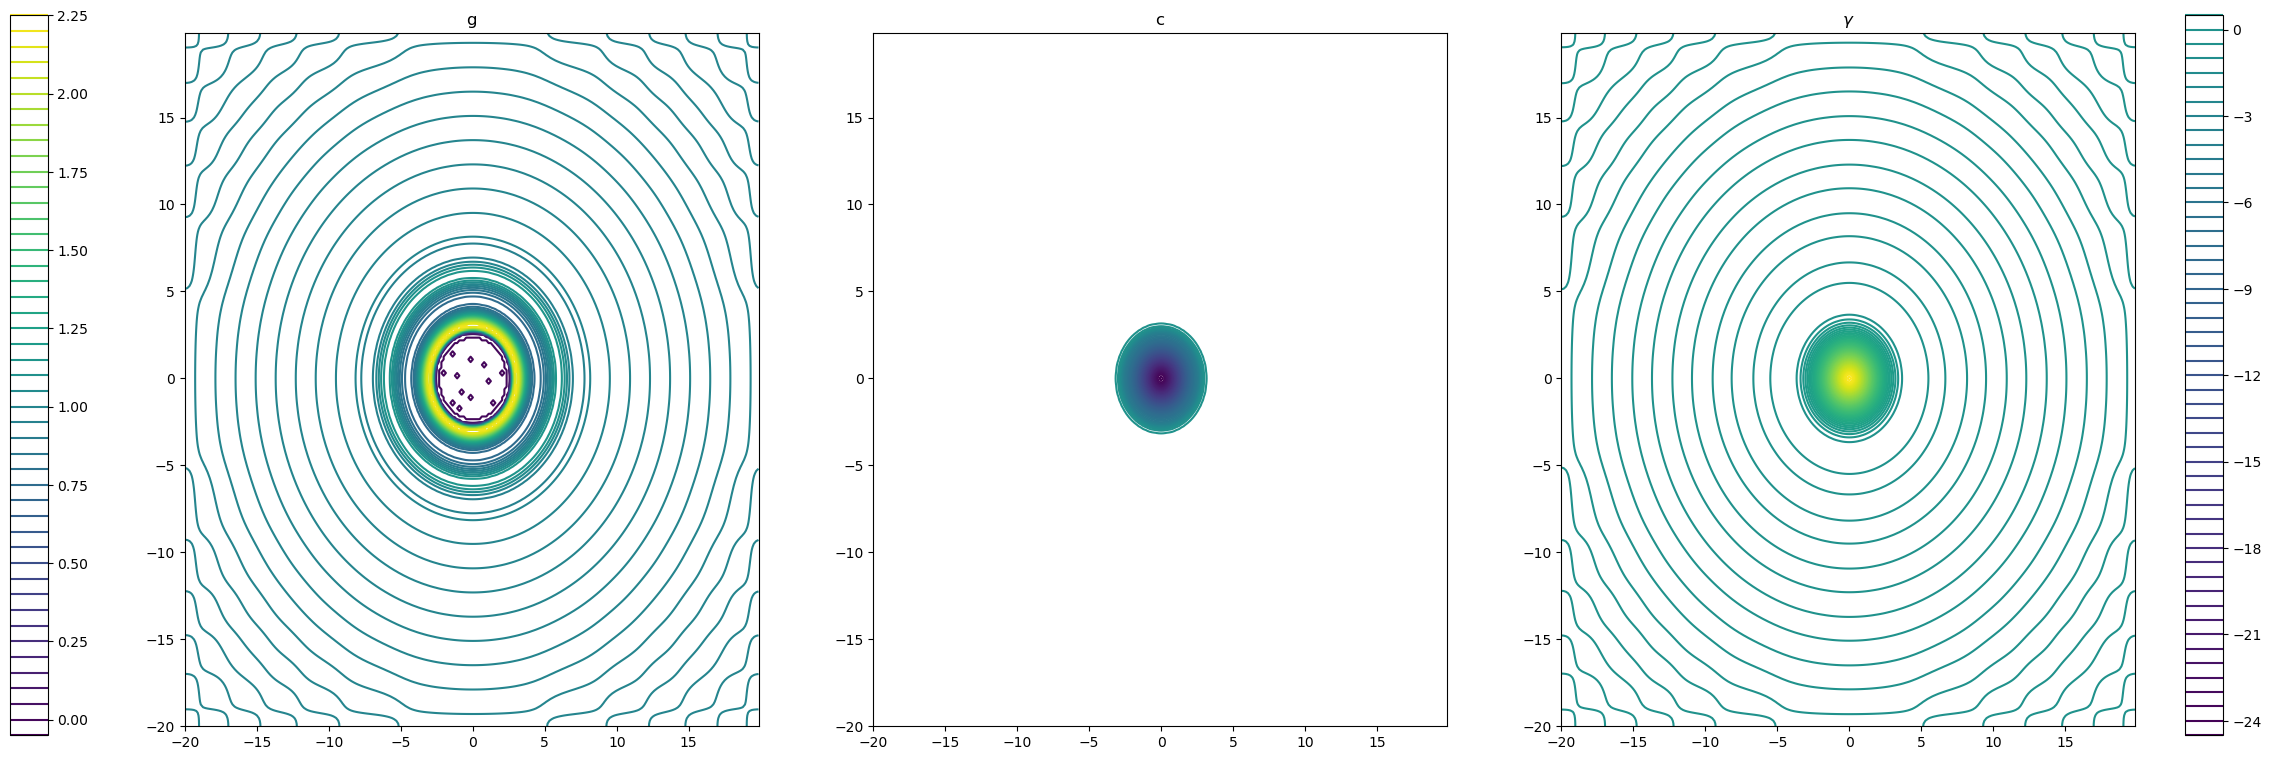

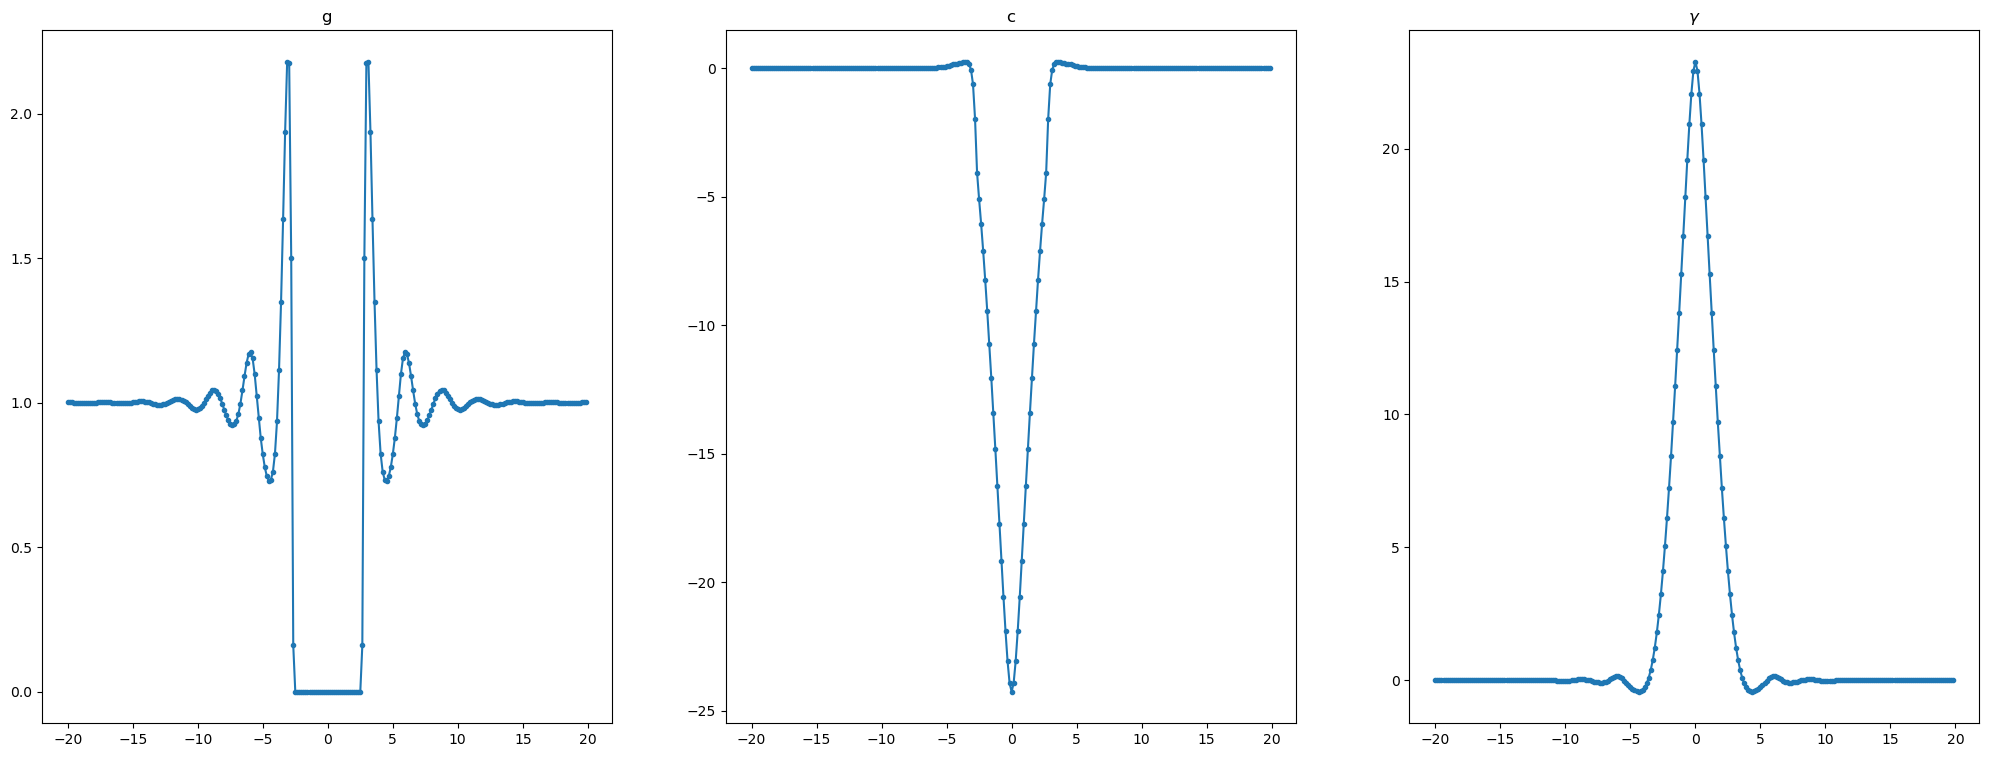

In [7]:
basis_set = [get_bspline_basis(r, i, 1.0) for i in [0, 1.0, 1.5, 2.5]]
# basis_set += [get_basis(r, i, 0.5) for i in np.arange(2.5, 6, 0.5)]

solver = OZSolventNR3DSSolver(
    grid=grid,
    closure=closure,
    basis_set=basis_set,
    temperature=temperature,
    solvent_type="o",
    rho_b=rho_b,
)
h, c = solver.solve(
    center,
    max_iterations=500,
    log_freq=10,
    error_tolerance=5e-5,
    nr_max_iterations=50,
    nr_step_size=0.5,
    nr_tolerance=0.0005,
)

visualize(grid, h, c, True)
visualize(grid, h, c, False)

Iteration 10; Residual 6.522e-03
	(Inner NR) Stop NR iterate at 15 steps, d_alpha 2.699e-04 smaller than tolerance 5.000e-04
Iteration 20; Residual 8.736e-04
	(Inner NR) Stop NR iterate at 26 steps, d_alpha 3.609e-04 smaller than tolerance 5.000e-04
Iteration 30; Residual 6.473e-05
	(Inner NR) Stop NR iterate at 35 steps, d_alpha 3.313e-04 smaller than tolerance 5.000e-04
Iteration 40; Residual 1.577e-05
Stop iterate at 40 steps, residual 1.577e-05 smaller than tolerance 5.000e-05
	(Inner NR) Stop NR iterate at 42 steps, d_alpha 2.533e-04 smaller than tolerance 5.000e-04
Run solve() for 7.039755821228027 s


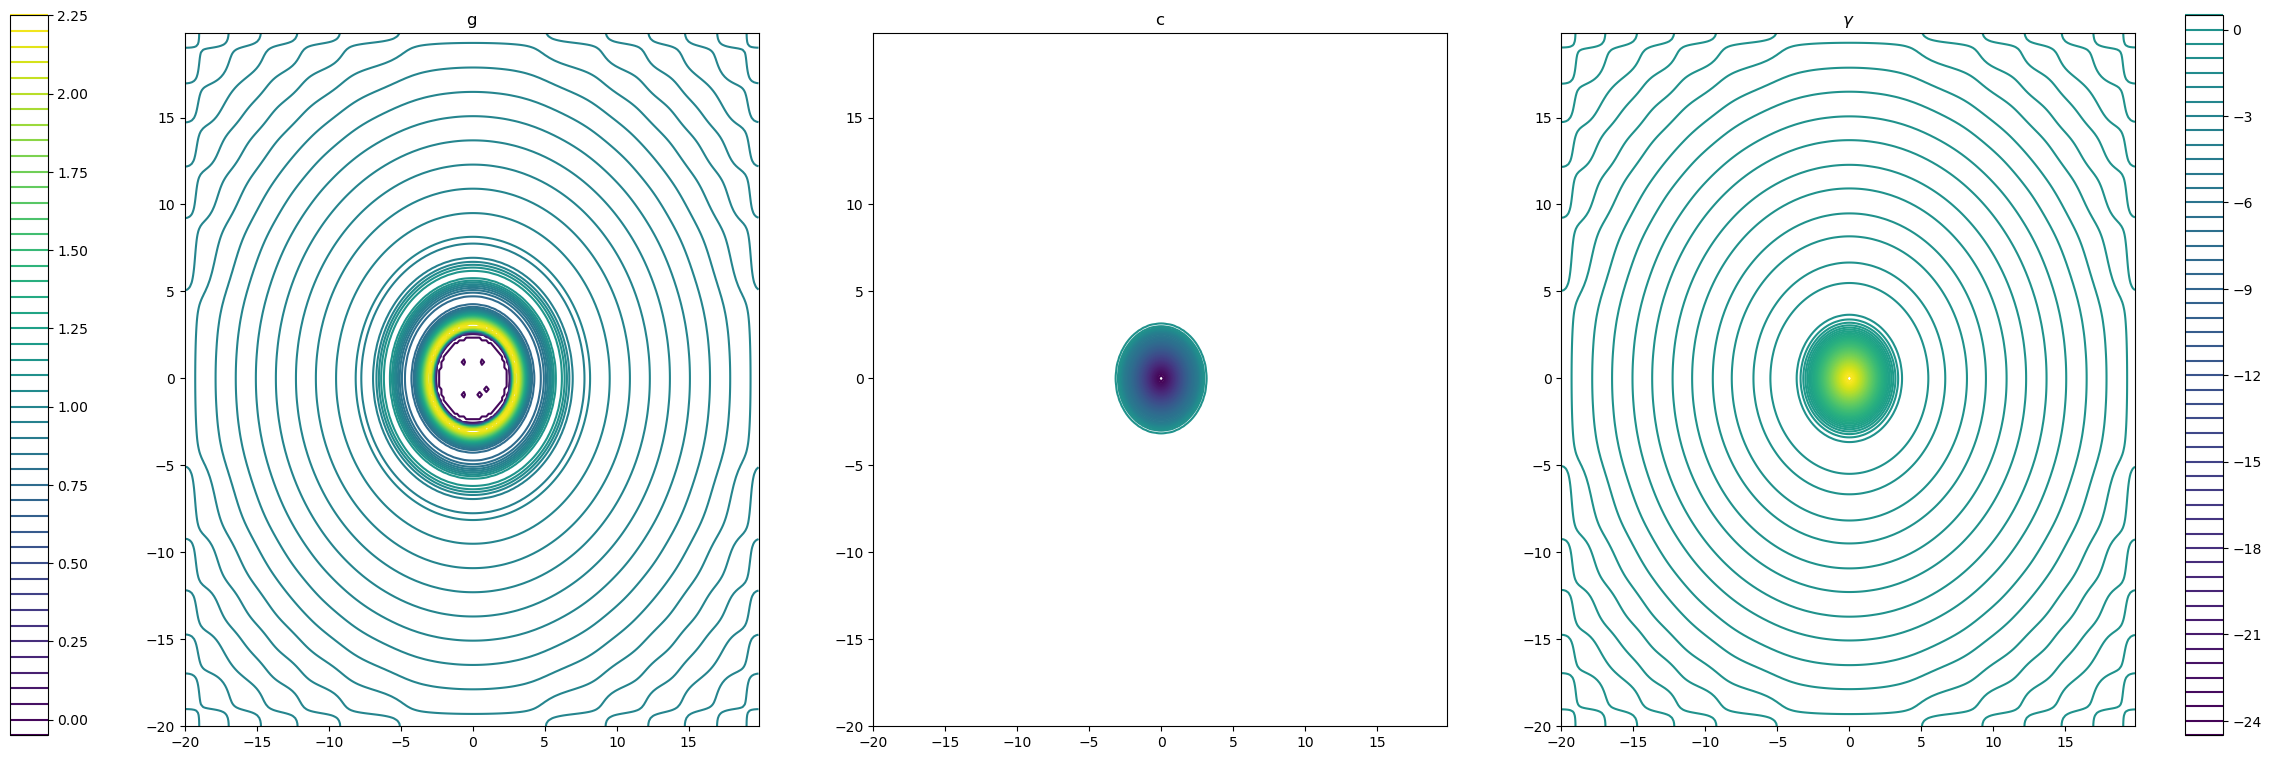

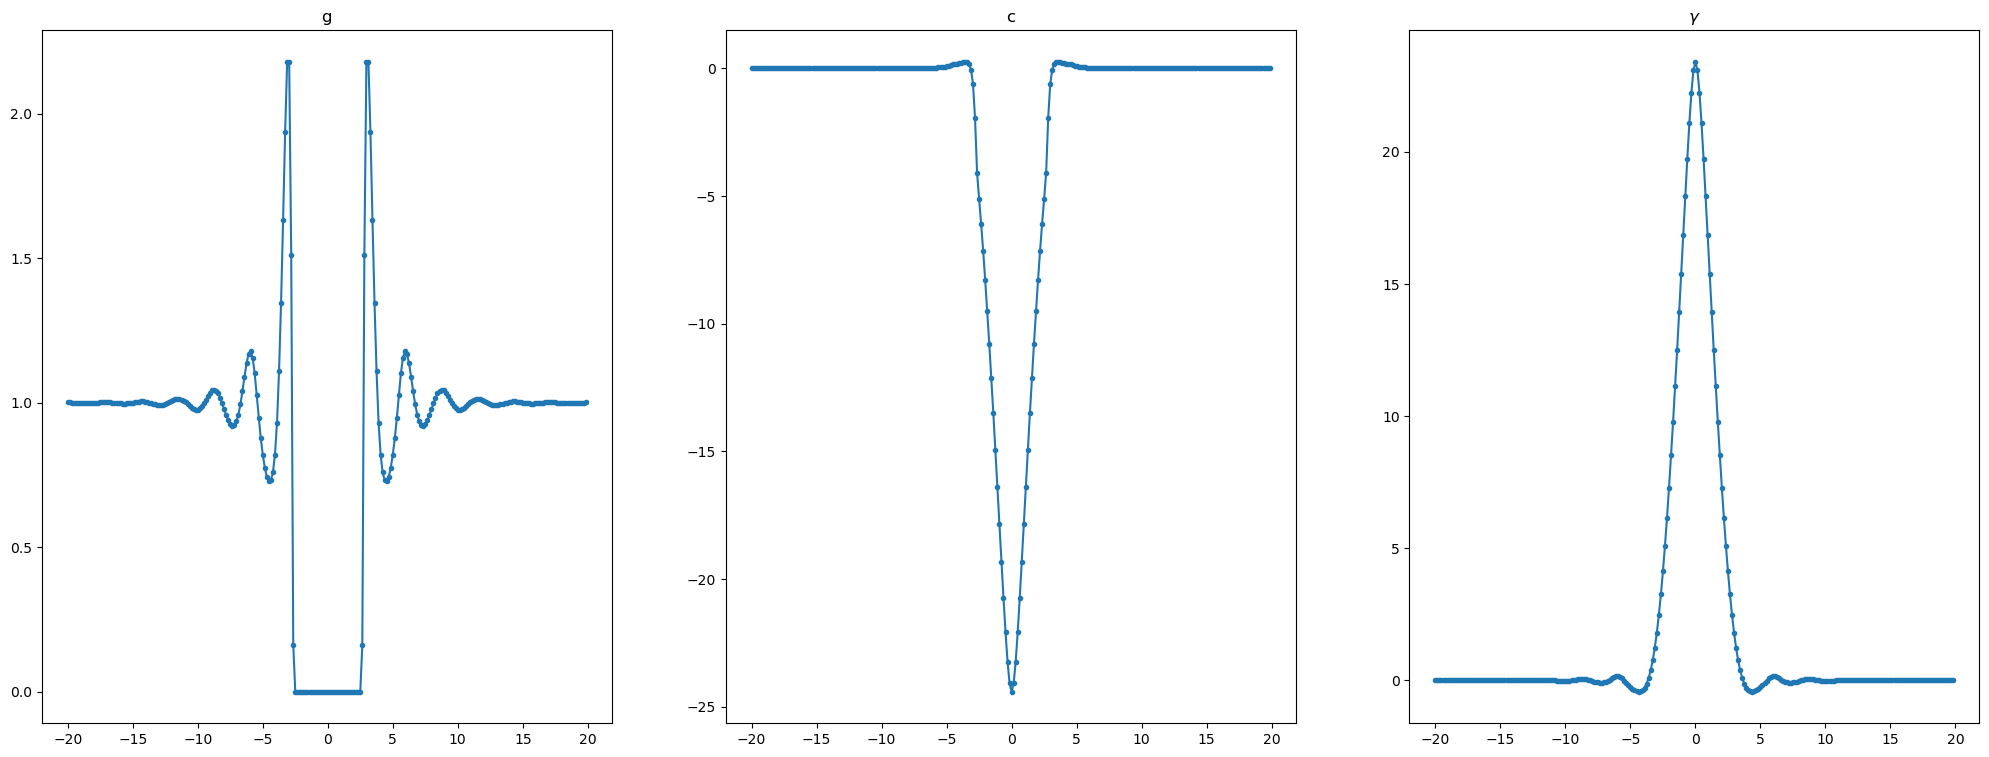

In [9]:
basis_set = [get_gaussian_basis(r, i, 1.0) for i in [0, 1.0, 1.5, 2.5]]
# basis_set += [get_basis(r, i, 0.5) for i in np.arange(2.5, 6, 0.5)]

solver = OZSolventNR3DSSolver(
    grid=grid,
    closure=closure,
    basis_set=basis_set,
    temperature=temperature,
    solvent_type="o",
    rho_b=rho_b,
)
h, c = solver.solve(
    center,
    max_iterations=500,
    log_freq=10,
    error_tolerance=5e-5,
    nr_max_iterations=50,
    nr_step_size=0.5,
    nr_tolerance=0.0005,
)

visualize(grid, h, c, True)
visualize(grid, h, c, False)